## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2021-12-15 11:06:00--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2021-12-15 11:06:01 (5.48 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t', '') for x in text]

--2021-12-15 20:02:12--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2021-12-15 20:02:12 (8.50 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.
import re

text = ''.join(text).lower()
text = re.sub('[^\nа-я ]', '', text)
text = re.sub(' +', ' ', text)
text = re.sub('\n\n+', '\n\n', text)
sections = list(filter(bool, text.split('\n\n')))
lines = text.split('\n')
lines = list(filter(bool, lines))
print(lines[:10])

['мой дядя самых честных правил', 'когда не в шутку занемог', 'он уважать себя заставил', 'и лучше выдумать не мог', 'его пример другим наука', 'но боже мой какая скука', 'с больным сидеть и день и ночь', 'не отходя ни шагу прочь', 'какое низкое коварство', 'полуживого забавлять']


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
class SpecialSymbol:
    start = '^'
    end = '$'

tokens = sorted(set(text))

tokens.append(SpecialSymbol.start)
tokens.append(SpecialSymbol.end)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
idx_to_token = {i: c for i, c in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {char: index for index, char in idx_to_token.items()}

In [6]:
from sklearn.model_selection import train_test_split

train_sections, test_sections = train_test_split(sections, test_size=0.2, shuffle=True)
train_lines, test_lines = train_test_split(lines, test_size=0.1, shuffle=True)
print('Train sections:', len(train_sections))
print('Test sections:', len(test_sections))
print()
print('Train lines:', len(train_lines))
print('Test lines:', len(test_lines))

Train sections: 309
Test sections: 78

Train lines: 4731
Test lines: 526


In [7]:
import numpy as np

  
def to_matrix(lines, max_len=None):
    """Casts a list of lines into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    matrix = np.zeros([len(lines), max_len + 2], dtype=int)
    matrix[:, 0] = token_to_idx[SpecialSymbol.start]
    for i in range(len(lines)):
        idx = [token_to_idx[c] for c in lines[i]]
        matrix[i, 1:len(idx)+1] = idx
        matrix[i, len(idx) + 1:] = token_to_idx[SpecialSymbol.end]

    return matrix

to_matrix(lines[: 10])

array([[34, 14, 16, 11,  1,  6, 33,  6, 33,  1, 19,  2, 14, 29, 23,  1,
        25,  7, 19, 20, 15, 29, 23,  1, 17, 18,  2,  4, 10, 13, 35, 35],
       [34, 12, 16,  5,  6,  2,  1, 15,  7,  1,  4,  1, 26, 21, 20, 12,
        21,  1,  9,  2, 15,  7, 14, 16,  5, 35, 35, 35, 35, 35, 35, 35],
       [34, 16, 15,  1, 21,  4,  2,  8,  2, 20, 30,  1, 19,  7,  3, 33,
         1,  9,  2, 19, 20,  2,  4, 10, 13, 35, 35, 35, 35, 35, 35, 35],
       [34, 10,  1, 13, 21, 25, 26,  7,  1,  4, 29,  6, 21, 14,  2, 20,
        30,  1, 15,  7,  1, 14, 16,  5, 35, 35, 35, 35, 35, 35, 35, 35],
       [34,  7,  5, 16,  1, 17, 18, 10, 14,  7, 18,  1,  6, 18, 21,  5,
        10, 14,  1, 15,  2, 21, 12,  2, 35, 35, 35, 35, 35, 35, 35, 35],
       [34, 15, 16,  1,  3, 16,  8,  7,  1, 14, 16, 11,  1, 12,  2, 12,
         2, 33,  1, 19, 12, 21, 12,  2, 35, 35, 35, 35, 35, 35, 35, 35],
       [34, 19,  1,  3, 16, 13, 30, 15, 29, 14,  1, 19, 10,  6,  7, 20,
        30,  1, 10,  1,  6,  7, 15, 30,  1, 10,  1, 15, 16

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [43]:
from torch import nn
import torch


class EvgenyRNN(nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.Sequential(
            nn.Linear(embedding_size + hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.decoder = nn.Linear(hidden_size, input_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input)
        rnn_input = torch.cat([input, hidden], dim=1)
        hidden_next = self.rnn(rnn_input)
        output = self.decoder(hidden_next)
        return hidden_next, output

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

In [44]:
def rnn_batch(char_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hidden = char_rnn.init_hidden(batch_size).to(device)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hidden, output = char_rnn(x_t, hidden)  # <-- here we call your one-step code
        logprobs.append(output)
        
    return torch.stack(logprobs, dim=1)

In [48]:
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


def rnn_loop(model, data_loader, test_data, optimizer, device, iterations=1000):
  history_loss = []
  history_test_loss = []

  for j in range(iterations):
      iteration_loss = []
      for i, data in enumerate(data_loader):
          batch = to_matrix(data)
          batch = torch.tensor(batch, dtype=torch.int64).to(device)
          logp_seq = rnn_batch(model, batch, device)
          predictions_logp = logp_seq[:, :-1].contiguous().view(-1, len(tokens))
          actual_next_tokens = batch[:, 1:].flatten()

          loss = nn.CrossEntropyLoss()(predictions_logp, actual_next_tokens)
          
          # train with backprop
          loss.backward()

          optimizer.step()
          optimizer.zero_grad()

          iteration_loss.append(loss.item())

      with torch.no_grad():
          batch = to_matrix(test_data)
          batch = torch.tensor(batch, dtype=torch.int64).to(device)
            
          seq = rnn_batch(model, batch, device)
          predictions = seq[:, :-1].contiguous().view(-1, len(tokens))
          actual = batch[:, 1:].flatten()
          test_loss = nn.CrossEntropyLoss()(predictions, actual)
          
          loss = np.array(iteration_loss).mean()
          history_loss.append(loss)
          history_test_loss.append(test_loss.item())

      clear_output(True)
      print('Loss:', loss)
      plt.plot(history_loss, label='loss')
      plt.plot(history_test_loss, label='test loss')
      plt.legend()
      plt.show()


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
loader = DataLoader(train_lines, batch_size=30, shuffle=True)
model = EvgenyRNN(input_size=len(token_to_idx))

model = model.to(device)
model.zero_grad()
opt = torch.optim.Adam(model.parameters())

cuda


Loss: 1.2994845305817038


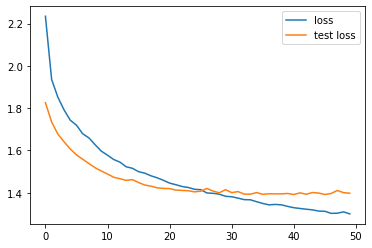

In [49]:
rnn_loop(model, loader, test_lines, opt, device, iterations=50)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [80]:
def generate_sample(char_rnn, seed_phrase='', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    assert len(seed_phrase)
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.init_hidden(1).to(device)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, i].shape, hid_state.shape)
        hid_state, __out = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        x_sequence = x_sequence.to(device)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        out = out.cpu()
        # Be really careful here with the model output
        # print(torch.exp(out))
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        # p_next = out.data.numpy()[0]
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = x_sequence.cpu()
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    s = ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])
    return s.replace('$', '').replace('^', '')

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('Temperature:', t)
    for i in range(3):
        print(generate_sample(model, seed_phrase='^в', max_length=100, temperature=t))

Temperature: 0.1
в после в сад не полной
в том с ней не полной старине
в только в полной полной
Temperature: 0.2
в полно в сад не старинный
в подобно в полу
в долго приятной не возором
Temperature: 0.5
в деревне приятно угад
вс татьяны я не предо в дослого в порой
в полно сердца то в рифмам страстей
Temperature: 1.0
в слышит танеками без мы горя
в люди с стысты моей друга ноги
вдохновить спожилась
Temperature: 2.0
вмишв
вдрало лаощеа
взувир хуг борщув божа 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [76]:
from torch import nn
import torch


class EvgenyLSTM(nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input)
        h_1, c_1 = self.lstm(input, (hidden[0], hidden[1]))
        output = self.decoder(c_1)
        return (h_1, c_1), output

    def init_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, requires_grad=True)

In [77]:
model_lstm = EvgenyLSTM(input_size=len(token_to_idx))

model_lstm = model_lstm.to(device)
model_lstm.zero_grad()
opt_lstm = torch.optim.Adam(model_lstm.parameters())

Loss: 1.1151879905145379


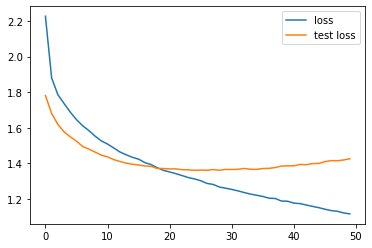

In [78]:
rnn_loop(model_lstm, loader, test_lines, opt_lstm, device, iterations=50)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [83]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('Temperature:', t)
    for i in range(3):
        print(generate_sample(model_lstm, seed_phrase='^к', max_length=100, temperature=t))

Temperature: 0.1
как то все волшебный полукон
как то вольностью молодой
как будто был он в сохранились
Temperature: 0.2
как будто был под старины
как будто было так же дни
когда не признанья привыка
Temperature: 0.5
как воспитанья молодой
когда ж глазами своей души
как под ним оставил стороне
Temperature: 1.0
красама он хлостлег трубил
куда хозязать на безе
кого лицах фартой мой природ
Temperature: 2.0
кропы дедяхает уцовзим
ка гуса ах лы чкадо идь вясидь
куфные кащитвов савесеннушь


Строчки данной модели заметно лучше предыдущей, LSTM победил

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [86]:
torch.save(model, 'model.pt')
torch.save(model_lstm, 'model_lstm.pt')

In [87]:
model_loaded = torch.load('model.pt')
model_lstm_loaded = torch.load('model_lstm.pt')

In [94]:
type(model)

__main__.EvgenyRNN

In [98]:
generate_sample(model_lstm, seed_phrase='^в', max_length=100, temperature=0.1)

'в том не постели в том собою'

In [99]:
from google.colab import files
files.download("model_lstm.pt") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)